In [1]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict
from matplotlib import pylab
import random

In [2]:
%load_ext PWE_NB_Extension

In [3]:
dataValues = [['"Jenifer"','"b1"','56000'],['"Tom"','"b1"','48000'],['"Tom"','"b1"','"/"']] # original fact database in list form
#clingo_rules = ['% schema data(ENDTYPE,ENDSIZE,ENDPOPULATION,COLOUR,TRANS,TYPE,SIZE,POPULATION)']

In [4]:
def turn_list_into_str(l):
    # small bug fix just for reformatting PWE results
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [5]:
def makeOriginal(dataValues,colour='black'):
    '''Transform the original dataset to a datalog fact database
    
    :param dataValues: Original data in list format
    :return clingoStart: Original data in fact database string
    '''
    clingoStart = 'data('
    for i,x in enumerate(dataValues):
        clingoStart += 'row'+str(i)+'('+','.join(x)+'),'
    clingoStart = clingoStart[:-1] 
    clingoStart += ').'
    return clingoStart

In [6]:
originalSetup = makeOriginal(dataValues)

In [7]:
originalSetup

'data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")).'

In [8]:
ASPRules(originalSetup) # display fact database with jupyter magic

'data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")).'

In [9]:
def addConversion(dataValues):
    '''Create datalog transformations to convert between edges and nodes
    
    :param dataValue: Original database in list format
    :return clingoHead+clingoBody: String containing the fact database and set of edge transformations in datalog for dataValue dataset
    '''
    variableList = []
    for y in range(len(dataValues)):
        variableList.append([chr(65+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length
        # note the above code will have a bug if there are > 26 rows, in this case change the naming convention 
    clingoHead = 'data(row0('
    clingoBody = 'e(data(row0('
    for x in range(len(variableList)):
        clingoHead += ','.join(variableList[x])
        clingoBody += ','.join(variableList[x])
        if x != len(variableList) -1:
            clingoHead += '), row'+str(x+1)+'('
            clingoBody += '), row'+str(x+1)+'('
        else:
            clingoHead += ')) :- '
            clingoBody += ')),data(row0(_,_,_), row1(_,_,_), row2(_,_,_)),trans(_,_)).'
    
    return clingoHead+clingoBody

In [10]:
edgeNodeConv = addConversion(dataValues)

In [11]:
ASPRules(edgeNodeConv)

'data(row0(A,B,C), row1(D,E,F), row2(G,H,I)) :- e(data(row0(A,B,C), row1(D,E,F), row2(G,H,I)),data(row0(_,_,_), row1(_,_,_), row2(_,_,_)),trans(_,_)).'

In [12]:
def makeSelect(dataValues,colour='orange'):
    ''' Make all SQL select transformations in datalog for the given database
    
    param: dataValues: Original database in list format
    return: clingoStart: String set of select transformations possible in datalog format
    '''
    # currently still only row by row for the toy dataset, multi row selects can be included fairly easily though
    # just add another loop and block out fewer rows
    # not needed right now as now rows share values
    clingoStart = ''
    variableList = []
    variableList2 = []
    dataValTotLength = len(dataValues[0])*len(dataValues)
    for y in range(len(dataValues)):
        variableList.append([chr(65+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length
        variableList2.append([chr(65+dataValTotLength+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length

    clingoStart =  []
    variString = 'row0('
    for x in range(len(variableList)):
        variString += ','.join(variableList[x])
        if x != len(variableList) -1:
            variString += '), row'+str(x+1)+'('
        else:
            variString += ')'

    #variString = ','.join(variables)
    for dataVal in dataValues:
        for x in range(len(variableList)):
            for y in range(len(variableList[x])):
                start = y
                end = y+x+1
                if end > len(variableList[x]):
                    end += -len(variableList[x])-1
                    templistvar = variableList[x][end:end+1]
                    templistvar.extend(variableList[x][start:])
                    templistdataVal = dataVal[end:end+1]
                    templistdataVal.extend(dataVal[start:])
                else:
                    templistvar = variableList[x][start:end]
                    templistdataVal = dataVal[start:end]
                listcomp = [v+'='+d+',' for v,d in zip(templistvar,templistdataVal)]
                
                newDataValues = [] # define arbitrary start values
                for i,z in enumerate(variableList[x]):
                    if z in templistvar:
                        newDataValues.append(z)
                    else:
                        newDataValues.append(chr(65+dataValTotLength+(len(variableList[x])*x)+i))
                
                finalVariString = 'row0('
                finalVariStringEnd = 'row0('
                arbStartValues = 'row0('
                for z in range(len(variableList)):
                    if z != x:
                        arbStartValues += ','.join(variableList2[z])
                        finalVariString += ','.join(['"-"']*len(variableList[z]))
                        finalVariStringEnd += ','.join(['_']*len(variableList[z]))
                    else:
                        arbStartValues += ','.join(newDataValues)
                        finalVariString += ','.join(variableList[z])
                        finalVariStringEnd += ','.join(variableList[z])
                    if z != len(variableList) -1 :
                        arbStartValues += '),row'+str(z+1)+'('
                        finalVariString += '),row'+str(z+1)+'('
                        finalVariStringEnd += '),row'+str(z+1)+'('
                    else:
                        arbStartValues += ')'
                        finalVariString += ')'
                        finalVariStringEnd += ')'
                #arbStartValues = ','.join(newDataValues)
                
                finalStringOG = "".join(listcomp)
                finalString = finalStringOG[:-1] +'.'
                finalStringOG = finalStringOG.replace('"','')
                finalStringOG = finalStringOG.replace(',','-')
                finalStringOG += '",'
                clingoStart.append('e(data('+finalVariString+'),data('+arbStartValues+'),trans("'+finalStringOG+colour+')) :- data('+finalVariStringEnd+'),data('+arbStartValues+'),'+finalString) 
    return clingoStart

In [13]:
selectCommands = makeSelect(dataValues) # may contain dupliucates

In [14]:
ASPRules('\n'.join(selectCommands))

'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Jenifer-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Jenifer".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=b1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="b1".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=56000-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=56000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Jenifer-E=b1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Jenifer",E="b1".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=b1-F=56000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="b1",F=56000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Jenifer-F=56000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Jenifer",F=56000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Jenifer-H=b1-I=56000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Jenifer",H="b1",I=56000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Jenifer-H=b1-I=56000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Jenifer",H="b1",I=56000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),trans("H=b1-I=56000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),H="b1",I=56000.\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Tom-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Tom".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=b1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="b1".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=48000-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=48000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Tom-E=b1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Tom",E="b1".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=b1-F=48000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="b1",F=48000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Tom-F=48000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Tom",F=48000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Tom-H=b1-I=48000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Tom",H="b1",I=48000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Tom-H=b1-I=48000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Tom",H="b1",I=48000.\ne(data(row0("-","-","-"),r

In [69]:
hackTerm = 'e(data(row0(A,B,C),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),trans("H=b1-I=/-",orange)) :- data(row0(A,B,C),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)), P="Tom", I=48000, M="Tom".'
# rule to translate between edges and nodes in datalog

In [70]:
updateCommand = 'e(data(row0(A,B,C),row1(D,E,F),row2(G,H,48000)),data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),trans("update","blue")) :- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),I="/".'
#doubleSelect = 'e(data(row0(A,B,C),row1(D,E,F),row2(G,E,48000)),data(row0(A,B,C),row1(D,E,F),row2(G,E,I)),trans("update","blue")):- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),I="/".'

In [71]:
doubleSelect = 'e(data(row0("-","-","-"),row1(M,N,O),row2(M,N,R)),data(row0(A,K,L),row1(M,N,O),row2(M,Q,R)),trans("N=DoubleTom-",orange)) :- data(row0(A,K,L),row1(M,N,O),row2(M,Q,R)),M="Tom".'

In [72]:
# this code block just joins together all data and rules in datalog

# clingo_rules = ['% schema row0(TYPE,SIZE,POPULATION)']
# clingo_rules.extend(['% schema row1(TYPE,SIZE,POPULATION)'])
# clingo_rules.extend(['% schema row2(TYPE,SIZE,POPULATION)'])
# clingo_rules = ['% schema data(row0(TYPE,SIZE,POPULATION),row1(TYPE,SIZE,POPULATION),row2(TYPE,SIZE,POPULATION))']
# clingo_rules.extend(['% schema e(data(row0(TYPE,SIZE,POPULATION),row1(TYPE,SIZE,POPULATION),row2(TYPE,SIZE,POPULATION)),data(row0(TYPE,SIZE,POPULATION),row1(TYPE,SIZE,POPULATION),row2(TYPE,SIZE,POPULATION)),trans(TRANSFORM,COLOUR))'])
clingo_rules = ['% schema data(row0,row1,row2)']
clingo_rules.extend(['% schema e(dataEnd,dataStart,trans)'])
clingo_rules.extend([originalSetup])
#clingo_rules.extend(['% schema database rules'])
clingo_rules.extend(selectCommands)
clingo_rules.extend([hackTerm])
# #clingo_rules.extend(['% schema project rules'])
#clingo_rules.extend(projectCommands)
#clingo_rules.extend(joinCommands)
clingo_rules.extend([edgeNodeConv])
clingo_rules.extend([updateCommand])
clingo_rules.extend([doubleSelect])

In [73]:
ASPRules('\n'.join(clingo_rules)) # display full set of rules

'% schema data(row0,row1,row2)\n% schema e(dataEnd,dataStart,trans)\ndata(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")).\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Jenifer-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Jenifer".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=b1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="b1".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=56000-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=56000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Jenifer-E=b1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Jenifer",E="b1".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=b1-F=56000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="b1",F=56000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Jenifer-F=56000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Jenifer",F=56000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Jenifer-H=b1-I=56000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Jenifer",H="b1",I=56000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Jenifer-H=b1-I=56000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Jenifer",H="b1",I=56000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),trans("H=b1-I=56000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),H="b1",I=56000.\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Tom-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Tom".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=b1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="b1".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=48000-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=48000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Tom-E=b1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Tom",E="b1".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=b1-F=48000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="b1",F=48000.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Tom-F=48000-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Tom",F=48000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Tom-H=b1-I=48000-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Tom",H="b1",I=48000.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Tom-H=b1-I=48000-",

In [74]:
clingo_rules

['% schema data(row0,row1,row2)',
 '% schema e(dataEnd,dataStart,trans)',
 'data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")).',
 'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Jenifer-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Jenifer".',
 'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=b1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="b1".',
 'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=56000-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=56000.',
 'e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Jenifer-E=b1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(

In [75]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input # find clingo solution for all allowed transformations and nodes

Output:


'Answer: 1\ndata(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")) data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1",48000)) data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")) data(row0("Jenifer","b1",56000),row1("-","-","-"),row2("-","-","-")) data(row0("-","-","-"),row1("Tom","b1",48000),row2("-","-","-")) data(row0("-","-","-"),row1("-","-","-"),row2("Tom","b1","/")) data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("-","-","-")) data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1",48000)) data(row0("-","-","-"),row1("-","-","-"),row2("Tom","b1",48000)) data(row0("-","-","-"),row1("-","-","-"),row2("-","-","-")) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("N=DoubleTom-",orange)) e(data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1",48000)),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("update","blue")) e(data(row0("-","-","-"),row1("-","-","-"),row2("Tom","b1","/")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("H=b1-I=/-",orange)) e(data(row0("-","-","-"),row1("-","-","-"),row2("Tom","b1","/")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("G=Tom-H=b1-I=/-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("D=Tom-F=48000-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("E=b1-F=48000-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("D=Tom-E=b1-",orange)) e(data(row0("Jenifer","b1",56000),row1("-","-","-"),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("C=56000-",orange)) e(data(row0("Jenifer","b1",56000),row1("-","-","-"),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("B=b1-",orange)) e(data(row0("Jenifer","b1",56000),row1("-","-","-"),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("A=Jenifer-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1",48000)),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1",48000)),trans("N=DoubleTom-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")),data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("N=DoubleTom-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1",48000)),data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("update","blue")) e(data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1",48000)),trans("H=b1-I=/-",orange)) e(data(row0("-","-","-"),row1("-","-","-"),row2("Tom","b1","/")),data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("H=b1-I=/-",orange)) e(data(row0("-","-","-"),row1("-","-","-"),row2("Tom","b1","/")),data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("G=Tom-H=b1-I=/-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1",48000)),trans("D=Tom-F=48000-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("-","-","-")),data(row0("-","-","-"),row1("Tom","b1",48000),row2("Tom","b1","/")),trans("D=Tom-F=48000-",orange)) e(data(row0("-","-","-"),row1("Tom","b1",48000),row2("-","-","-")),data(row0("Jenifer","b1",56000),row1("Tom","b1",48000),row2("Tom","b1",48000)),trans("E=b1-F=48000-",orange)) e(data(

In [76]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False) # generate all possible worlds

Number of Models: 1


In [77]:
pw_rels_dfs.keys()

dict_keys(['data_3', 'e_3'])

In [78]:
pw_rels_dfs['data_3']

,pw,row0,row1,row2
0,1,"[row0, ""Jenifer"", ""b1"", 56000]","[row1, ""Tom"", ""b1"", 48000]","[row2, ""Tom"", ""b1"", ""/""]"
1,1,"[row0, ""Jenifer"", ""b1"", 56000]","[row1, ""Tom"", ""b1"", 48000]","[row2, ""Tom"", ""b1"", 48000]"
2,1,"[row0, ""-"", ""-"", ""-""]","[row1, ""Tom"", ""b1"", 48000]","[row2, ""Tom"", ""b1"", ""/""]"
3,1,"[row0, ""Jenifer"", ""b1"", 56000]","[row1, ""-"", ""-"", ""-""]","[row2, ""-"", ""-"", ""-""]"
4,1,"[row0, ""-"", ""-"", ""-""]","[row1, ""Tom"", ""b1"", 48000]","[row2, ""-"", ""-"", ""-""]"
5,1,"[row0, ""-"", ""-"", ""-""]","[row1, ""-"", ""-"", ""-""]","[row2, ""Tom"", ""b1"", ""/""]"
6,1,"[row0, ""Jenifer"", ""b1"", 56000]","[row1, ""Tom"", ""b1"", 48000]","[row2, ""-"", ""-"", ""-""]"
7,1,"[row0, ""-"", ""-"", ""-""]","[row1, ""Tom"", ""b1"", 48000]","[row2, ""Tom"", ""b1"", 48000]"
8,1,"[row0, ""-"", ""-"", ""-""]","[row1, ""-"", ""-"", ""-""]","[row2, ""Tom"", ""b1"", 48000]"
9,1,"[row0, ""-"", ""-"", ""-""]","[row1, ""-"", ""-"", ""-""]","[row2, ""-"", ""-"", ""-""]"


In [79]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data_3'].applymap(turn_list_into_str)


In [80]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [81]:
def transExtract(row):
    a = row['trans']
    loc1 = a.find('(')
    loc2 = a.find(',')
    loc3 = a.find(')')
    transition = a[loc1+1:loc2]
    colour = a[loc2+1:loc3]
    return {'colour':colour,'transition':transition}

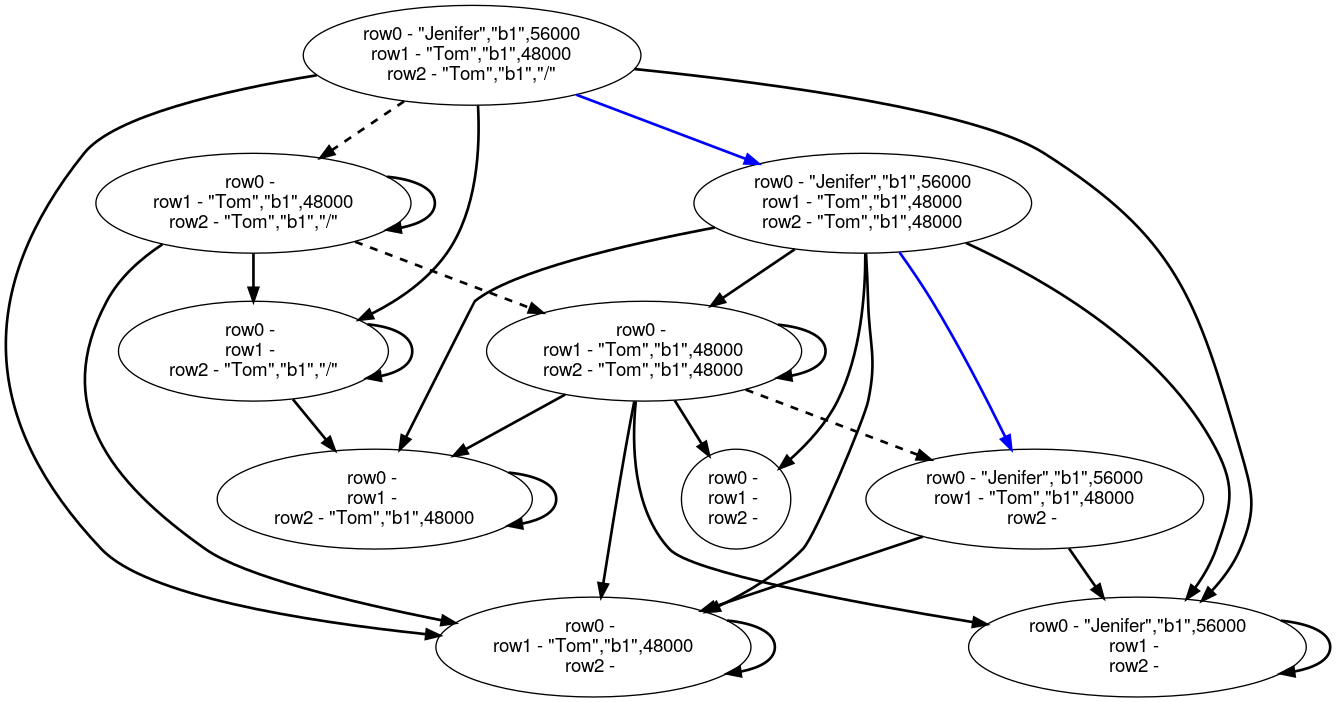

In [90]:
# This cell is graph generation for the example used in the Hilda paper

G = nx.DiGraph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

startNode1 = 'row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")'
endNode1 = 'row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")'

startNode2 = 'row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")'
endNode2 = 'row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1",48000)'

startNode3 = 'row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")'
endNode3 = 'row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1",48000)'

startNode4 = 'row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1",48000)'
endNode4 = 'row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("-","-","-")'

startNode5 = 'row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1",48000)'
endNode5 = 'row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("-","-","-")'

# G.add_edge('row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")','row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")',colour='red')
# edges.append(('row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")','row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")'))

for i, row in pwe_e3_new_format.iterrows():
    start_node = smallConvert(row['dataStart'])
    end_node = smallConvert(row['dataEnd'])
    startList.append(start_node)
    endList.append(end_node)
    
    if start_node == startNode1 and end_node == endNode1:
        colour = 'black'#transExtract(row)['colour']
        style = 'dashed'
    elif start_node == startNode2 and end_node == endNode2:
        colour = 'black'
        style = 'dashed'
    elif start_node == startNode3 and end_node == endNode3:
        colour = 'blue'
        style = 'solid'
    elif start_node == startNode4 and end_node == endNode4:
        colour = 'blue'
        style = 'solid'
    elif start_node == startNode5 and end_node == endNode5:
        colour = 'black'
        style = 'dashed'
    else:
        colour = 'black'
        style = 'solid'
    #colour = 'blue'#transExtract(row)['colour']
#     start_node = start_node.replace('row0(','')
#     start_node = start_node.replace('row1(','')
    start_node = start_node.replace('(',' - ')
    start_node = start_node.replace(')','')
    start_node = start_node.replace('"-","-","-"','')
    
#     end_node = end_node.replace('row0(','')
#     end_node = end_node.replace('row1(','')
    end_node = end_node.replace('(',' - ')
    end_node = end_node.replace(')','')
    end_node = end_node.replace('"-","-","-"','')
    
#     start_node = start_node.replace('row0\n','')
#     end_node = end_node.replace('row0\n','')
    
#     start_node = start_node.replace('row1\n','')
#     end_node = end_node.replace('row1\n','')
    
#     start_node = start_node.replace('row2\n','')
#     end_node = end_node.replace('row2\n','')
    
    
    #start_node = start_node.replace('row0(','')
    G.add_edge(start_node, end_node, penwidth=2,color=colour,style=style)
    edges.append((start_node, end_node))

# print('row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")')
# print('row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")')
# G.add_edge('row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")','row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")',colour='red')
# edges.append(('row0("Jenifer","b1",56000)\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")','row0("-","-","-")\nrow1("Tom","b1",48000)\nrow2("Tom","b1","/")'))
    
    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'dot'
    
draw(G,format='png',filename='selectProjectJoin.png')
    
# G.graph['rankdir'] = 'TB'

In [67]:
#calculation of path length from start to finish

app = []

start_node = startNode1
end_node = endNode2

#     start_node = start_node.replace('row1(','')
start_node = start_node.replace('(',' - ')
start_node = start_node.replace(')','')
start_node = start_node.replace('"-","-","-"','')

#     end_node = end_node.replace('row0(','')
#     end_node = end_node.replace('row1(','')
end_node = end_node.replace('(',' - ')
end_node = end_node.replace(')','')
end_node = end_node.replace('"-","-","-"','')

for path in nx.all_simple_paths(G,source=start_node,target=end_node):
    app.append(path)
print(len(app))


17


In [91]:
# graph creation for join commands only

G = nx.DiGraph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    colour = transExtract(row)['colour']
    if colour == 'blue':
        start_node = smallConvert(row['dataStart'])
        end_node = smallConvert(row['dataEnd'])
        startList.append(start_node)
        endList.append(end_node)
        G.add_edge(start_node, end_node, penwidth=2,color=colour)
        edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'
    
draw(G,format='png',filename='joinOnly.png')
    
# G.graph['rankdir'] = 'TB'

In [92]:
# graph creation for join commands 

G = nx.DiGraph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    colour = transExtract(row)['colour']
    if colour == 'red':
        start_node = smallConvert(row['dataStart'])
        end_node = smallConvert(row['dataEnd'])
        startList.append(start_node)
        endList.append(end_node)
        G.add_edge(start_node, end_node, penwidth=2,color=colour)
        edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'
    
draw(G,format='png',filename='projectOnly.png')
    
# G.graph['rankdir'] = 'TB'

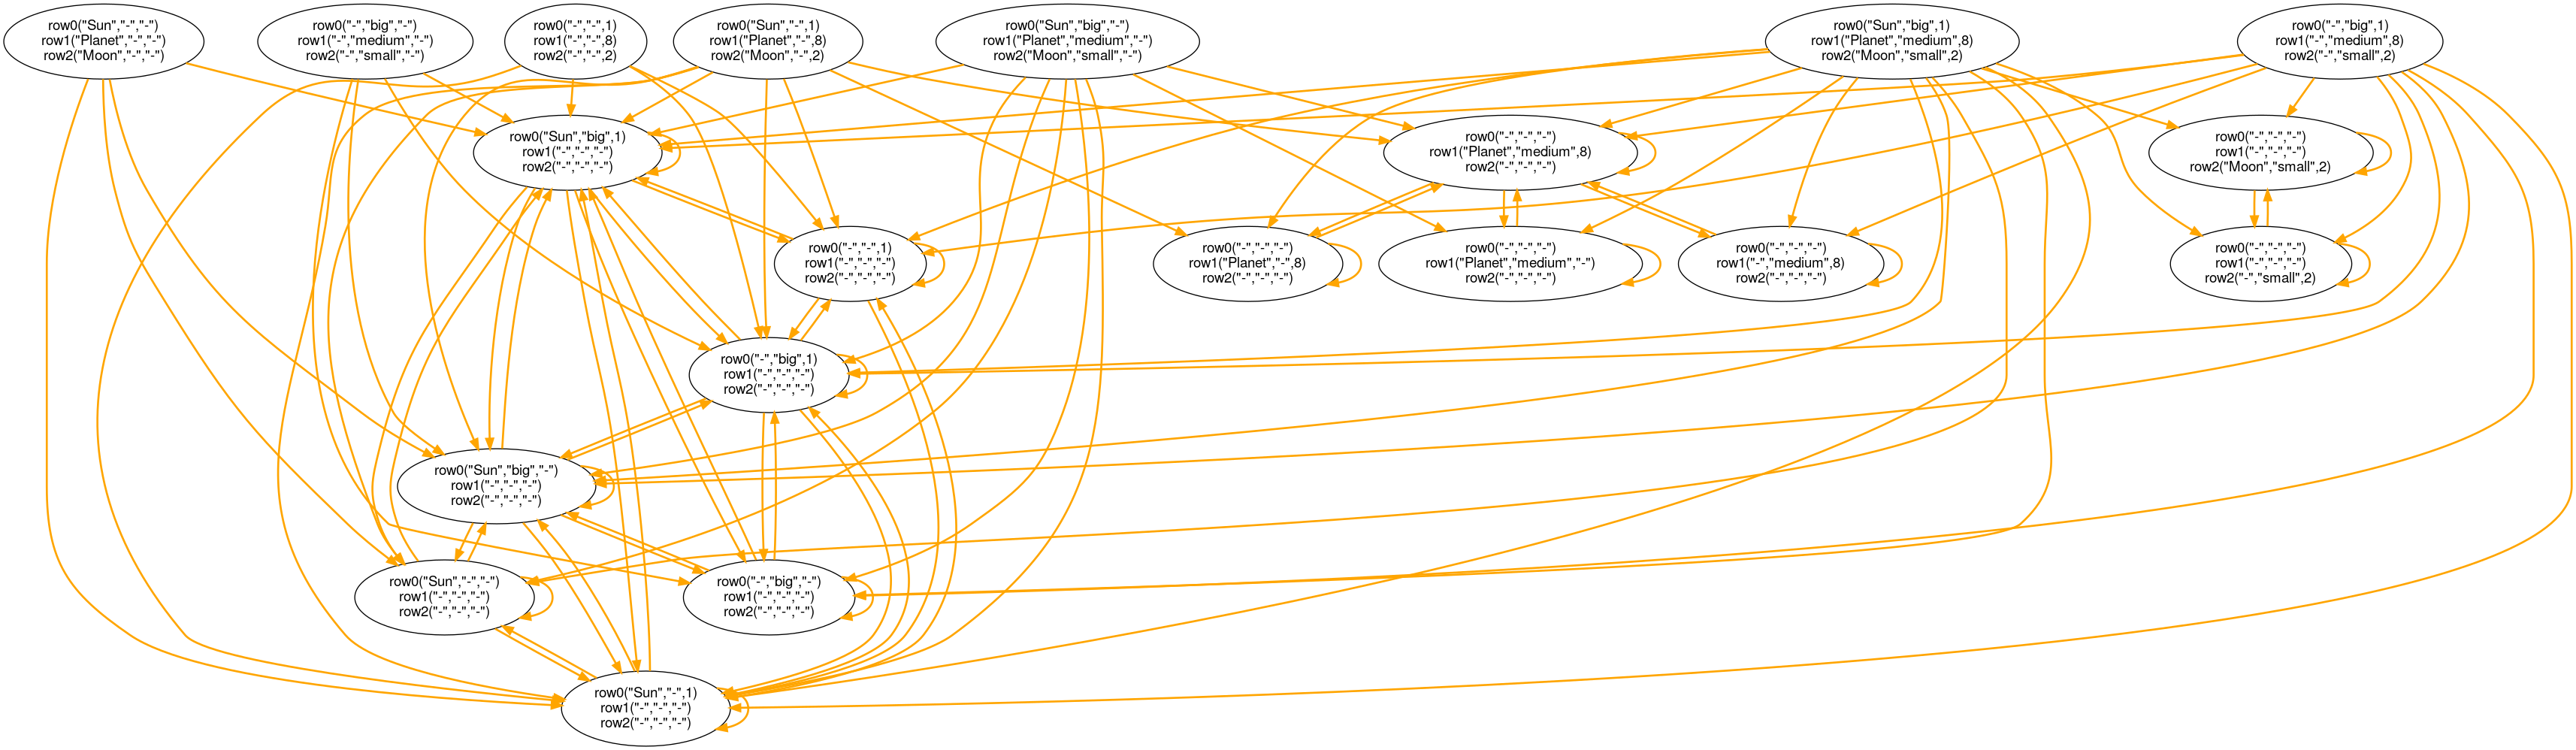

In [49]:
# graph creation for select commands only

G = nx.DiGraph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    colour = transExtract(row)['colour']
    if colour == 'orange':
        start_node = smallConvert(row['dataStart'])
        end_node = smallConvert(row['dataEnd'])
        startList.append(start_node)
        endList.append(end_node)
        G.add_edge(start_node, end_node, penwidth=2,color=colour)
        edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'
    
draw(G,format='png',filename='selectOnly.png')
    
# G.graph['rankdir'] = 'TB'

In [153]:
# find a specific target node in graph

targetNum = 10
targets = []
for x in range(targetNum):
    targets.append(random.randint(0,len(pwe_e3_new_format['dataEnd'])-1))
targetPos = [pwe_e3_new_format['dataEnd'][x] for x in targets]
targetNewFormat = [smallConvert(t) for t in targetPos]

In [133]:
endValues = random.randint(0,len(pwe_e3_new_format['dataEnd']))

In [52]:
target = pwe_e3_new_format['dataEnd'][10]

In [53]:
start = pwe_e3_new_format['dataStart'][0]

In [148]:
target


'data(row0("Sun","big",1),row1("-","-","-"),row2("-","-","-"))'

In [130]:
newStart = smallConvert(start)
#print(newStart)

In [131]:
newTarget = smallConvert(target)
#print(newTarget)

In [127]:
def getGraphStats(G,target,start):
    '''Calculate stats for the graph between two nodes 
    :param G: Input DiGraph  
    :param target: Target node to calculate paths to
    :param: start: Start node for the graph
    :return: [APP,DIFFNUM,smallpp]: [# of all possible paths, # of difference invarience paths, size of smallest possible path]
    '''
    allPaths = []
    #for sources in dataValuesNonStr:
    singlePath = []
    for path in nx.all_simple_paths(G,source=start,target=target):
        singlePath.append(path)
    allPaths.append(singlePath)
    APP = len(allPaths[0])
    
    allPSorted = sorted(allPaths[0])
    allPSet = set(frozenset(x) for x in allPSorted)
    DIFF = [list(x) for x in allPSet]
    DIFFNUM = len(DIFF)
    
    minPath = nx.shortest_path(G,start,target)
    smallpp = len(minPath)
    
    return [APP,DIFFNUM,smallpp]

In [154]:
statsTot = []
for x in targetNewFormat:
    try:
        statsTot.append(getGraphStats(G,x,newStart))
    except:
        print('redo ',x)

redo  row0("-","-","-")
row1("-","-","-")
row2("-","-","-")
redo  row0("-","-","-")
row1("-","-","-")
row2("-","-",2)


In [143]:
stats = getGraphStats(G,targetNewFormat[-1],newStart)

In [155]:
statsTot

[[0, 0, 2],
 [4, 4, 2],
 [223, 48, 2],
 [2, 2, 2],
 [343, 51, 2],
 [263, 50, 2],
 [343, 51, 2],
 [223, 48, 2]]